In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os 

from pyuoi.decomposition import UoI_NMF_Base
from neuropacks import ECOG
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.dimensionality_reduction_utils import *

%matplotlib inline

# Analyze BCV NMF Results

In [2]:
results_path = os.path.join(os.environ['HOME'],
                            'fits/uoineuro/dimensionality_reduction/nmf_ecog.h5')

In [3]:
nmf_bcv_results = h5py.File(results_path, 'r')

In [4]:
n_hyperparameters = len(nmf_bcv_results)
n_ranks = len(nmf_bcv_results['l1_ratio0.01_alpha0.001/errors'])
errors = np.zeros((n_hyperparameters, n_ranks))
groups = []

for idx, hyperparameter in enumerate(list(nmf_bcv_results)):
    groups.append(nmf_bcv_results[hyperparameter])
    errors[idx] = nmf_bcv_results[hyperparameter]['errors'][:]

In [5]:
min_group = groups[np.argmin(np.min(errors, axis=1))]
min_rank = np.argmin(min_group['errors']) + 1

In [6]:
print(min_group)
print(min_rank)

<HDF5 group "/l1_ratio0._alpha1.0" (1 members)>
29


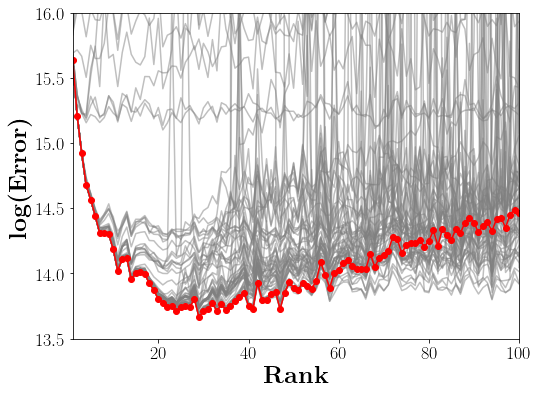

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

[ax.plot(np.arange(1, 101), np.log(errors[idx]),
         color='gray', alpha=0.5)
 for idx in range(n_hyperparameters)]
ax.plot(np.arange(1, 101), np.log(min_group['errors'][:]),
        marker='o', color='red')
ax.set_xlim([1, 100])
ax.set_ylim([13.5, 16])
ax.tick_params(labelsize=18)
ax.set_xlabel(r'\textbf{Rank}', fontsize=25)
ax.set_ylabel(r'\textbf{log(Error)}', fontsize=25)
plt.savefig('nmf_bcv_results.pdf', bbox_inches='tight')

# Compare NMF / UoI NMF Basis Sets

In [8]:
#data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
#grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')
data_path = '/storage/data/ecog/r32_b7.mat'
grid_path = '/storage/data/ecog/grdid.mat'

ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path)
dead_electrodes = [0, 19, 21]

In [9]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG'
)

In [10]:
# kill the dead indices
Y[:, dead_electrodes] = 0
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))

In [11]:
nmf = NMF(
    n_components=29,
    l1_ratio=0.0,
    alpha=1.0,
    beta_loss='frobenius',
    solver='cd',
    max_iter=1000,
    init='random')

In [12]:
nmf.fit(Y)

NMF(alpha=1.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
    max_iter=1000, n_components=29, random_state=None, shuffle=False,
    solver='cd', tol=0.0001, verbose=0)

In [13]:
nmf_for_uoi = NMF(
    n_components=29,
    l1_ratio=0.0,
    alpha=1.0,
    beta_loss='frobenius',
    solver='cd',
    max_iter=1000,
    init='random')

In [14]:
kmeans = KMeans(n_clusters=29, n_init=20)

In [15]:
uoi = UoI_NMF_Base(n_boots=30,
                   ranks=[29],
                   nmf=nmf_for_uoi,
                   cluster=kmeans)

In [16]:
uoi.fit(Y)

UoI_NMF_Base(cluster=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                            max_iter=300, n_clusters=29, n_init=20, n_jobs=None,
                            precompute_distances='auto', random_state=None,
                            tol=0.0001, verbose=0),
             cons_meth=<function mean at 0x7fd08e141170>, logger=None,
             n_boots=30,
             nmf=NMF(alpha=1.0, beta_loss='frobenius', init='random',
                     l1_ratio=0.0, max_iter=1000, n_components=29,
                     random_state=None, shuffle=False, solver='cd', tol=0.0001,
                     verbose=0),
             nnreg=<function UoI_NMF_Base.__initialize.<locals>.<lambda> at 0x7fd05a5a80e0>,
             random_state=None, ranks=(29,), use_dissimilarity=True)

In [17]:
ordering1, ordering2 = match_bases(nmf.components_, uoi.components_)
ordering1 = ordering1.astype('int')
ordering2 = ordering2.astype('int')

In [18]:
tuning_path = os.path.join(os.environ['HOME'],
                           'fits/uoineuro/tuning/ecog/ecog_tuning.h5')
tuning_results = h5py.File(tuning_path, 'r')
tuning_coefs = np.median(tuning_results['uoi_lasso_bic/tuning_coefs'], axis=0)
pref_frequencies = calculate_best_frequencies_ecog(tuning_coefs, ecog,
                                                   return_grid=True,
                                                   omit_idxs=dead_electrodes)

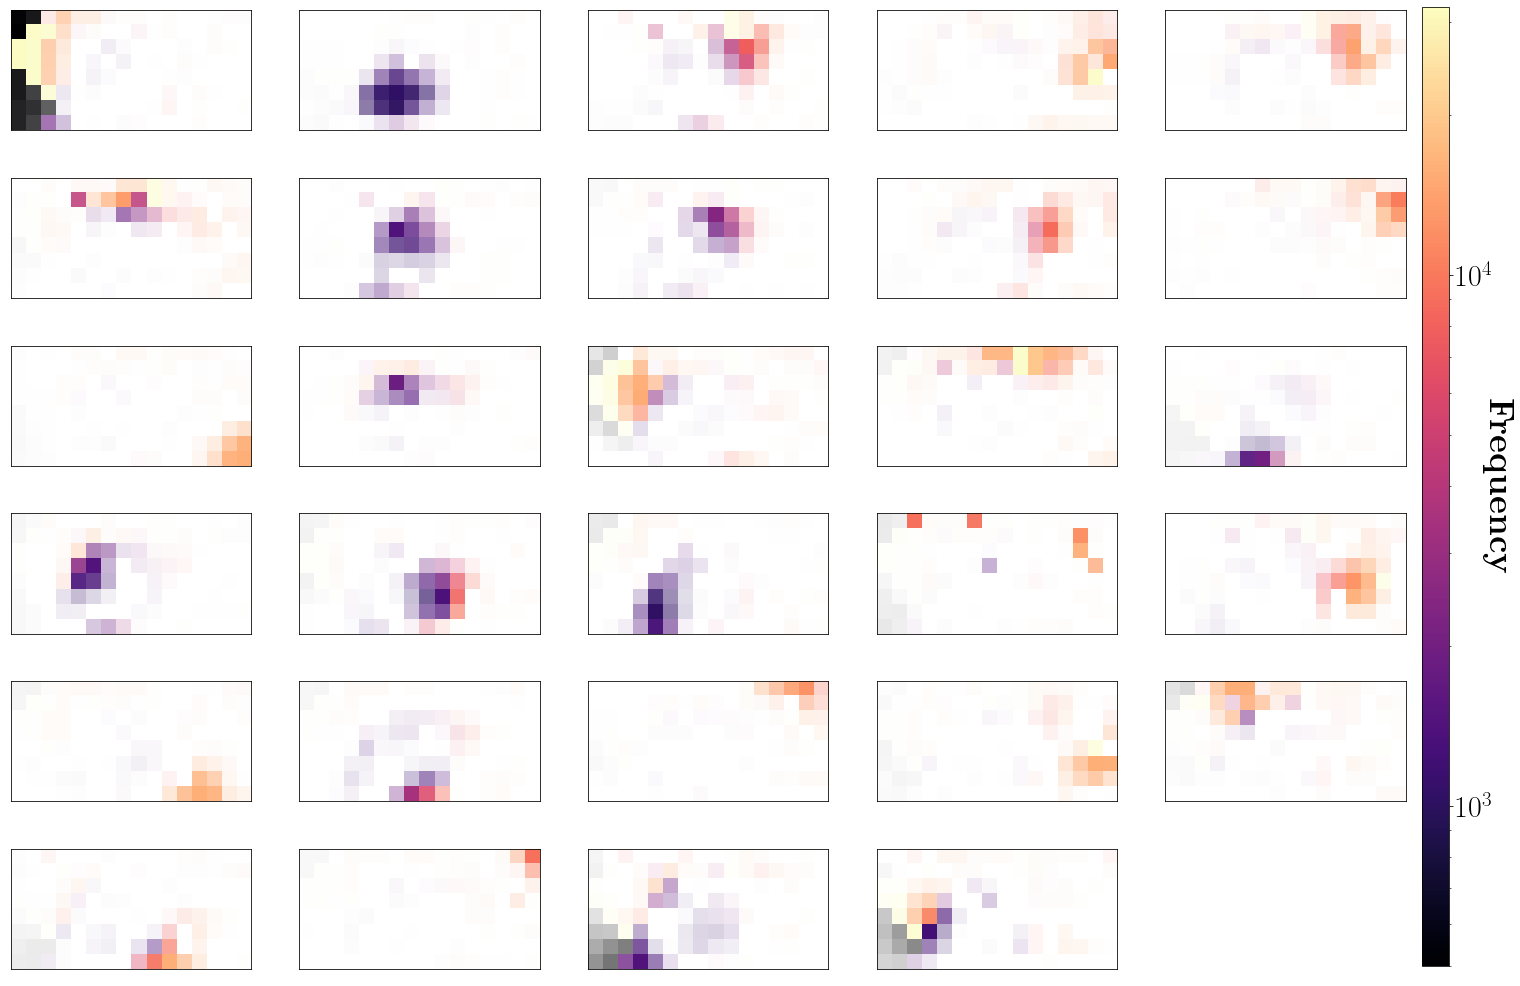

In [20]:
fig, axes = plot_ecog_bases(nmf.components_, ecog,
                            pref_freqs=pref_frequencies,
                            cmap='magma',
                            ordering=ordering1,
                            n_cols=5)
axes[-1, -1].axis('off')

# create colorbar
fig_invert = fig.transFigure.inverted()
ax_bottom_right_x, ax_bottom_right_y = \
    fig_invert.transform(axes[-1, -1].transAxes.transform([1.0, 0.]))
ax_top_right_x, ax_top_right_y = \
    fig_invert.transform(axes[0, -1].transAxes.transform([1.0, 1.0]))
cax = fig.add_axes([ax_bottom_right_x + 0.009,
                    ax_bottom_right_y + 0.01,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y - 0.015])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                                                              vmax=ecog.freq_set[-1]),
                                                                              cmap='magma'),
                  cax=cax)
cb.ax.tick_params(labelsize=30)
cb.set_label(r'\textbf{Frequency}',
             fontsize=35,
             rotation=270,
             labelpad=20)
plt.savefig('nmf_bcv_best_fit.pdf', bbox_inches='tight')
plt.show()

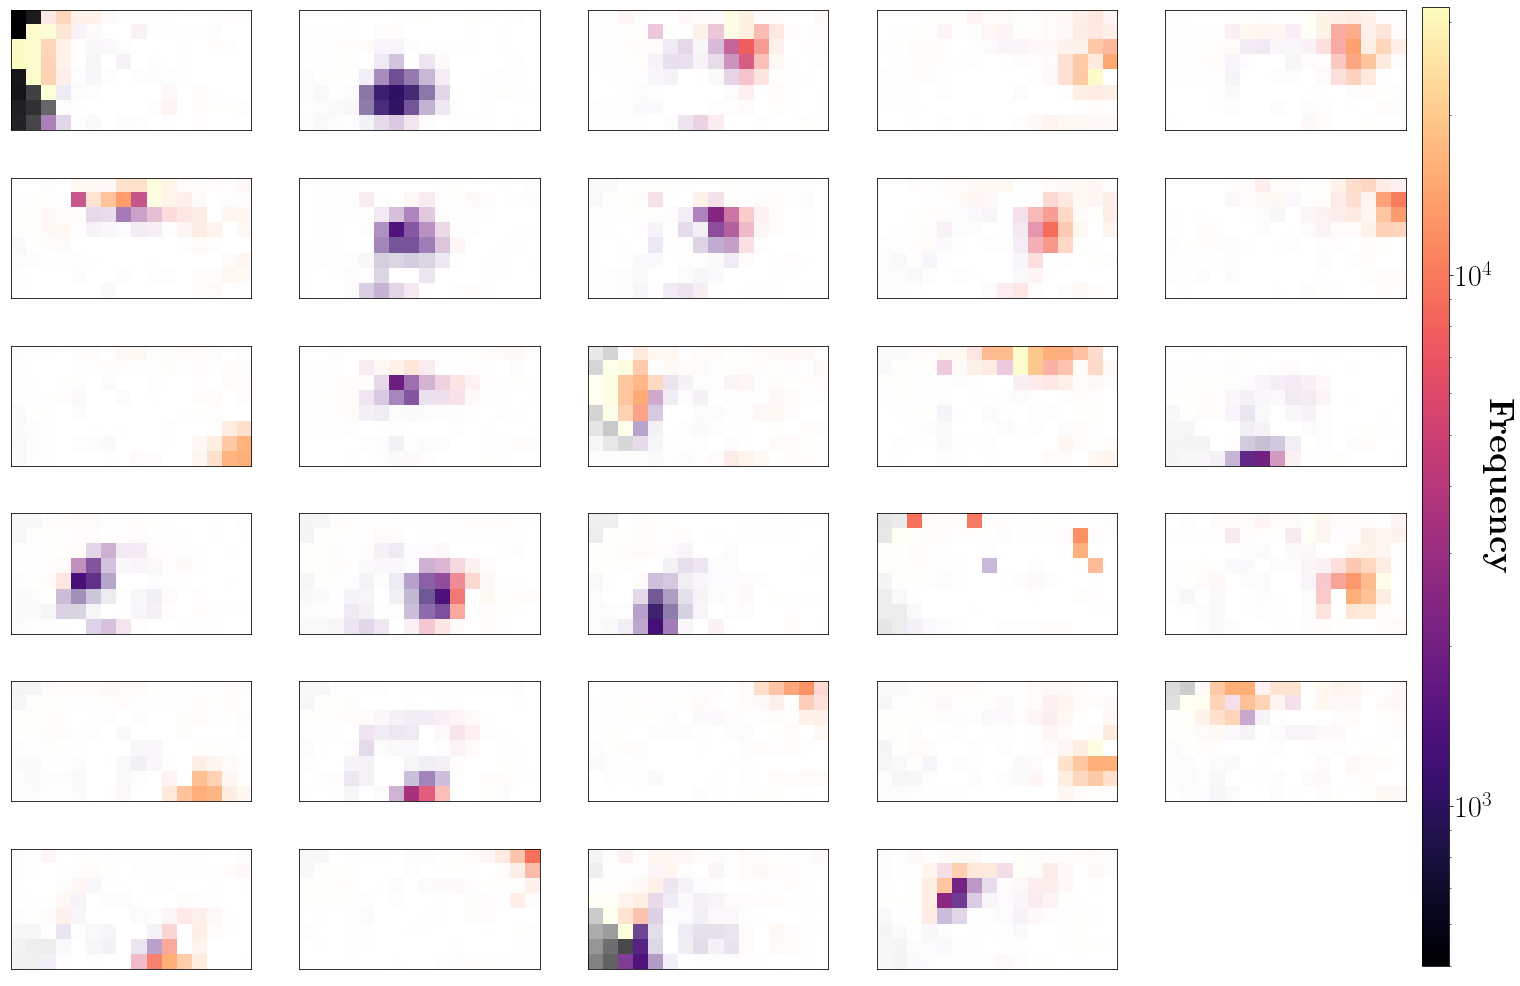

In [21]:
fig, axes = plot_ecog_bases(uoi.components_, ecog,
                            pref_freqs=pref_frequencies,
                            cmap='magma',
                            ordering=ordering2,
                            n_cols=5)
axes[-1, -1].axis('off')

# create colorbar
fig_invert = fig.transFigure.inverted()
ax_bottom_right_x, ax_bottom_right_y = \
    fig_invert.transform(axes[-1, -1].transAxes.transform([1.0, 0.]))
ax_top_right_x, ax_top_right_y = \
    fig_invert.transform(axes[0, -1].transAxes.transform([1.0, 1.0]))
cax = fig.add_axes([ax_bottom_right_x + 0.009,
                    ax_bottom_right_y + 0.01,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y - 0.015])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                                                              vmax=ecog.freq_set[-1]),
                                                                              cmap='magma'),
                  cax=cax)
cb.ax.tick_params(labelsize=30)
cb.set_label(r'\textbf{Frequency}',
             fontsize=35,
             rotation=270,
             labelpad=20)
plt.savefig('uoi_nmf_matched_bcv.pdf', bbox_inches='tight')
plt.show()

# Analyze UoI NMF Dissimilarity Results

In [2]:
results_path = os.path.join(os.environ['HOME'],
                            'fits/uoineuro/dimensionality_reduction/uoi_nmf_ecog.h5')

In [3]:
results = h5py.File(results_path, 'r')

In [11]:
n_hyperparameters = len(results)
n_ranks = len(results['l1_ratio0.01_alpha0.001/dissimilarity'])
dissimilarities = np.zeros((n_hyperparameters, n_ranks))
groups = []

for idx, hyperparameter in enumerate(list(results)):
    groups.append(results[hyperparameter])
    dissimilarities[idx] = results[hyperparameter]['dissimilarity'][:]

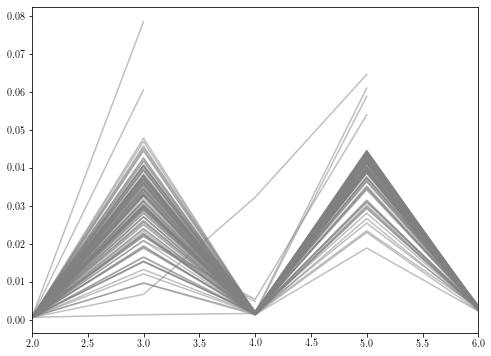

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

[ax.plot(np.arange(2, 41), dissimilarities[idx],
         color='gray', alpha=0.5)
 for idx in range(n_hyperparameters)]

ax.set_xlim([2, 6])
plt.show()

In [17]:
np.argmin(np.min(dissimilarities, axis=1))

7

In [32]:
ruff = np.nan_to_num(dissimilarities, nan=100)

In [35]:
np.argmin(np.min(ruff, axis=1))

34

In [28]:
type(dissimilarities[7][9])

numpy.float64

In [27]:
dissimilarities == np.nan

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [30]:
np.nan == dissimilarities[7][9]

False

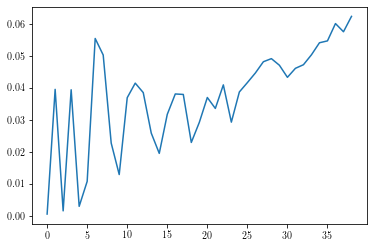

In [37]:
plt.plot(ruff[34])

In [44]:
#data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
#grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')
data_path = '/storage/data/ecog/r32_b7.mat'
grid_path = '/storage/data/ecog/grdid.mat'

ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path)
dead_electrodes = [0, 19, 21]

In [45]:
tuning_path = os.path.join(os.environ['HOME'],
                           'fits/uoineuro/tuning/ecog/ecog_tuning.h5')
tuning_results = h5py.File(tuning_path, 'r')
tuning_coefs = np.median(tuning_results['uoi_lasso_bic/tuning_coefs'], axis=0)
pref_frequencies = calculate_best_frequencies_ecog(tuning_coefs, ecog,
                                                   return_grid=True,
                                                   omit_idxs=dead_electrodes)

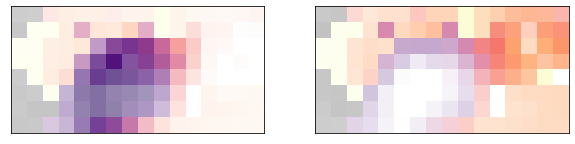

In [48]:
fig, axes = plot_ecog_bases(groups[34]['components'][:], ecog,
                            pref_freqs=pref_frequencies,
                            cmap='magma',
                            n_cols=2)